## Strategy

> To trade the VIX 

### *Signals*

> Touch of lower bound = close sell and build long position

> Cross of upper std dev multiple = sell entire position


In [395]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

In [622]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df.head()

# identifying the VIX
vix = df['Series 28'].iloc[300:500]
vix

Day
300     91.566866
301    104.840319
302    103.293413
303     92.814371
304     95.109780
          ...    
495    160.329341
496    152.894212
497    138.722555
498    136.776447
499    137.325349
Name: Series 28, Length: 200, dtype: float64

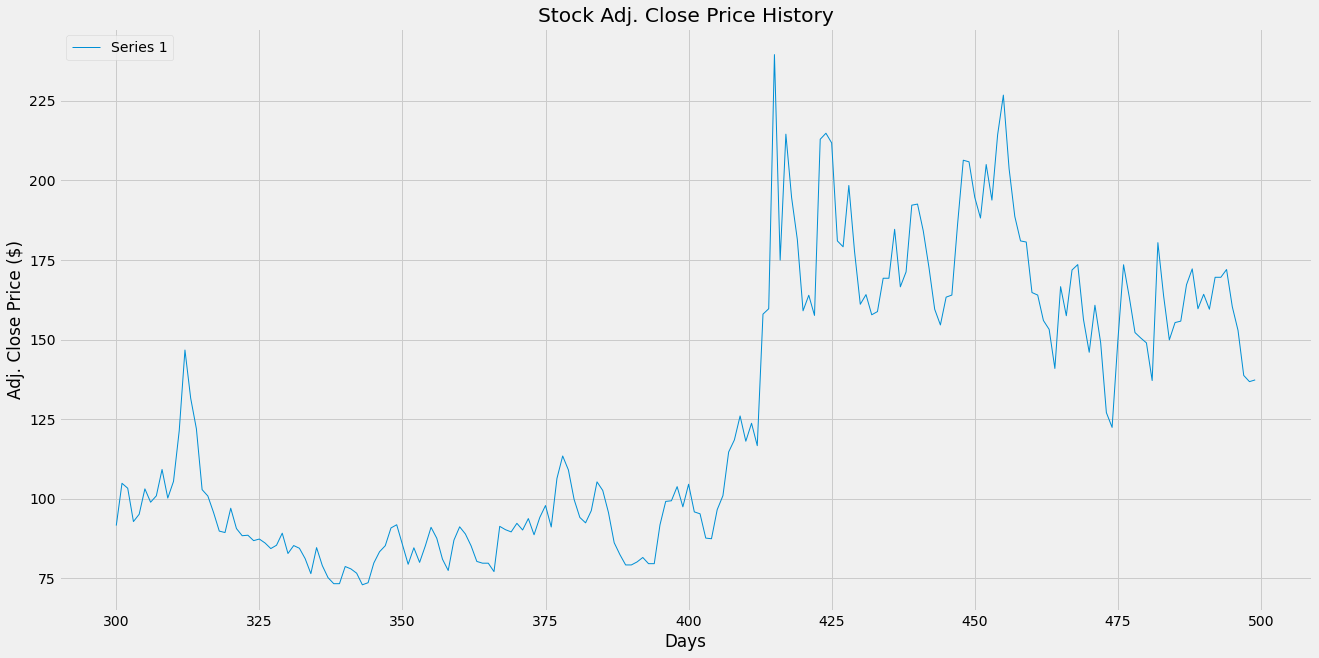

In [623]:
#Visualise the data
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth = 1)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()

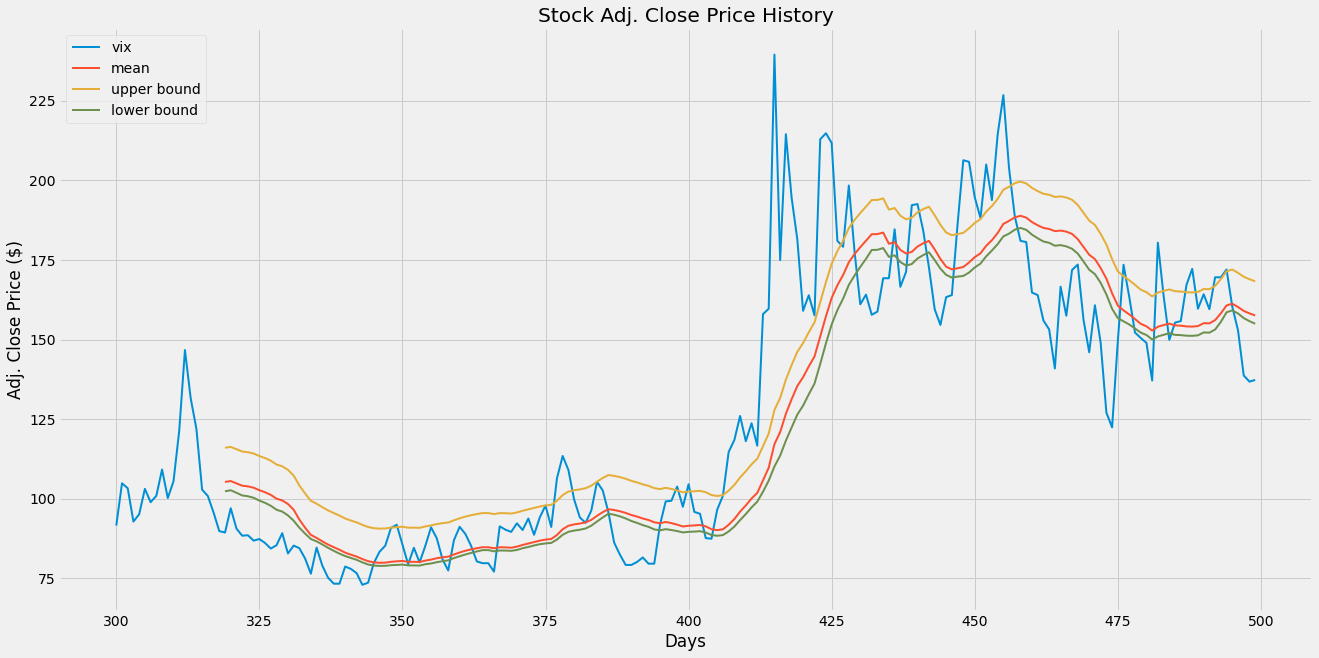

In [624]:
#Visualise the moving average and upper and lower bounds

# inputs
window_mean = 20
window_std = 20
upper_bound = 0.25   # number of stdv from mean
lower_bound = 0.2     # number of stdv below mean

# plotting
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth=2, label='vix')
plt.plot(vix.rolling(window=window_mean).mean(), linewidth=2, label='mean')
plt.plot(vix.rolling(window=window_mean).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
plt.plot(vix.rolling(window=window_mean).mean() - lower_bound*vix.rolling(window=window_std).std()\
         , linewidth=2, label='lower bound')
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [625]:
# vix strategy

def vixen(data, window_mean, upper_bound, lower_bound, trade_size_sell, trade_size_buy, cap_size): 
    # generating simple moving average
    
    # constraints
    max_cap = 500000
    position = 0
    
    # data - is the series to generate signals for
    # window - is the window used to generate the average
    # lag - is how far % past the average before a signal is generated
    SMA = data.rolling(window = window_mean).mean()
    cap = data.rolling(window=200).mean() + cap_size*vix.std()
    upper_bounds = SMA + upper_bound*vix.std()
    lower_bounds = SMA - lower_bound*vix.std()
    
    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
    run_pos = []
    trade = []
      
    #flag = 1: long position, flag = 0: short position, flag = -1: no position
    flag = 0

    for i in range(len(data)):
        # closing trade at end of session
        trades_to_close = position/trade_size_sell
        
#        if i == int((len(data)-(trades_to_close))):
#            if position > 0:
#                sigPriceBuy.append(np.nan)
#                sigPriceSell.append(data.iloc[i])
#                run_pos.append(position)
#                position -= trade_size_sell
#                trade.append(-trade_size_sell)
        # Touch of lower bound = close sell and build long position until max trade reached
        if (data.iloc[i]<lower_bounds.iloc[i]) and (position<max_cap):# and (data.iloc[i]<cap[i+data.index[0]]):
            sigPriceBuy.append(data.iloc[i])
            sigPriceSell.append(np.nan)
            run_pos.append(position)
            position += trade_size_buy
            trade.append(trade_size_buy)
            
        elif (data.iloc[i]>upper_bounds.iloc[i]) and (position>0):# and (data.iloc[i]-data.iloc[i-1]>0):
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(data.iloc[i])
            run_pos.append(position)
            if position > trade_size_sell:
                position -= trade_size_sell
                trade.append(-trade_size_sell)
            else:
                position -= trade_size_buy
                trade.append(-trade_size_buy)

        else: 
            run_pos.append(position)
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
            trade.append(np.nan)

    return (sigPriceBuy, sigPriceSell, run_pos, trade)

buy_sell_data = vixen(vix, window_mean, upper_bound, lower_bound, 100000, 50000, 0.9)

## Strategy Tester Cell

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


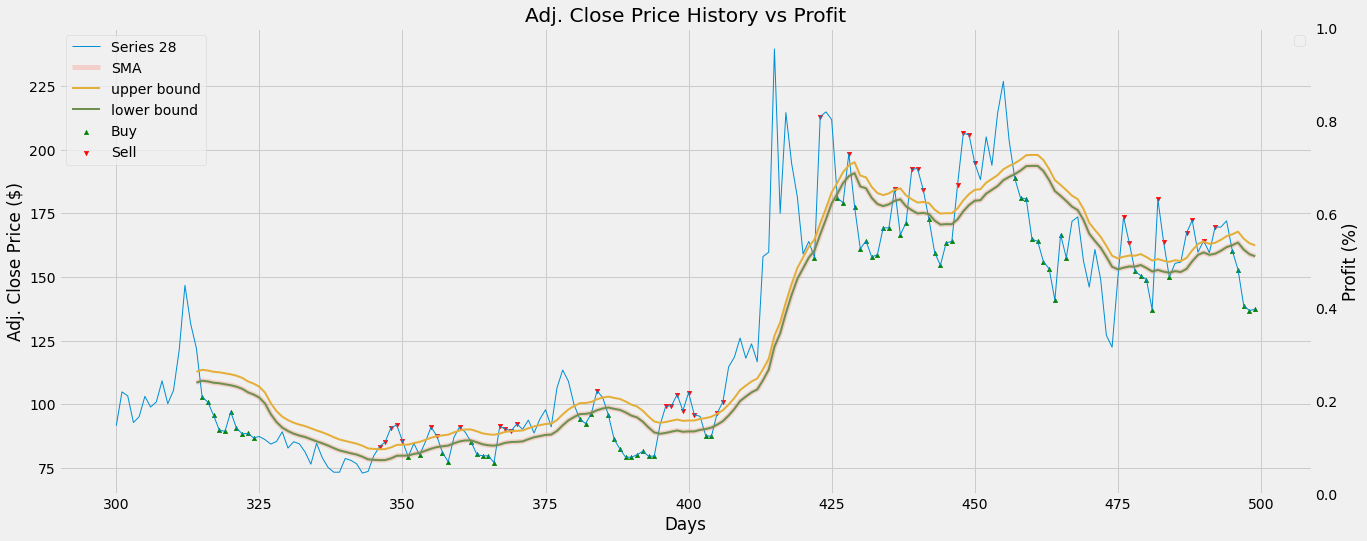

In [626]:
# testing basic strategy
# To test, change window and the series used

# =========================================
# variables
window_mean = 15
upper_bound = .1   # number of stdv from mean
lower_bound = 0.0    # number of stdv below mean
trade_size_sell = 100000    # daily trade increment
trade_size_buy = 50000    # daily trade increment
cap_size = 0
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = vixen(vix, window_mean, upper_bound, lower_bound, trade_size_sell, trade_size_buy, cap_size)

# format outputs
trades = pd.DataFrame(vix.index)
trades['Price'] = vix.values
trades['Running Position'] = buy_sell_data[2]
trades['Trades'] = buy_sell_data[3]
trades['Profit'] = (trades['Price'][1::]-trades['Price'].shift(1)[0:-1]) * trades['Running Position']
trades['Risk Free Return'] = trades['Running Position'] * trades['Price'].shift(1)[0:-1]*((1.031)**(1/365)-1)
trades['Cumulative Profit'] = trades['Profit'].cumsum()
trades = trades.set_index('Day')

# visualise test
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# adding price data
ax1.plot(vix, label='Series 28', alpha=1, linewidth=1)
ax1.plot(vix.rolling(window=window_mean).mean(), label='SMA', alpha=0.2, linewidth=5)
ax1.plot(vix.rolling(window=window_mean).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
ax1.plot(vix.rolling(window=window_mean).mean() - lower_bound*vix.std()\
         , linewidth=2, label='lower bound')
#ax1.plot(vix.rolling(window=200).mean() + cap_size*vix.std(), linewidth=1)
# plot profit
#ax2.plot(trades.index, 100*trades['Cumulative Profit']/(500000*85), linewidth=4, color='green', label='Profit', alpha=.3)
# adding indicators
ax1.scatter(vix.index, buy_sell_data[0], [20],label='Buy', marker='^', color='green')
ax1.scatter(vix.index, buy_sell_data[1], [20],label='Sell', marker='v', color='red')
ax1.set_title('Adj. Close Price History vs Profit')
ax1.set_xlabel('Days')
ax1.set_ylabel('Adj. Close Price ($)')
ax2.set_ylabel('Profit (%)')
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

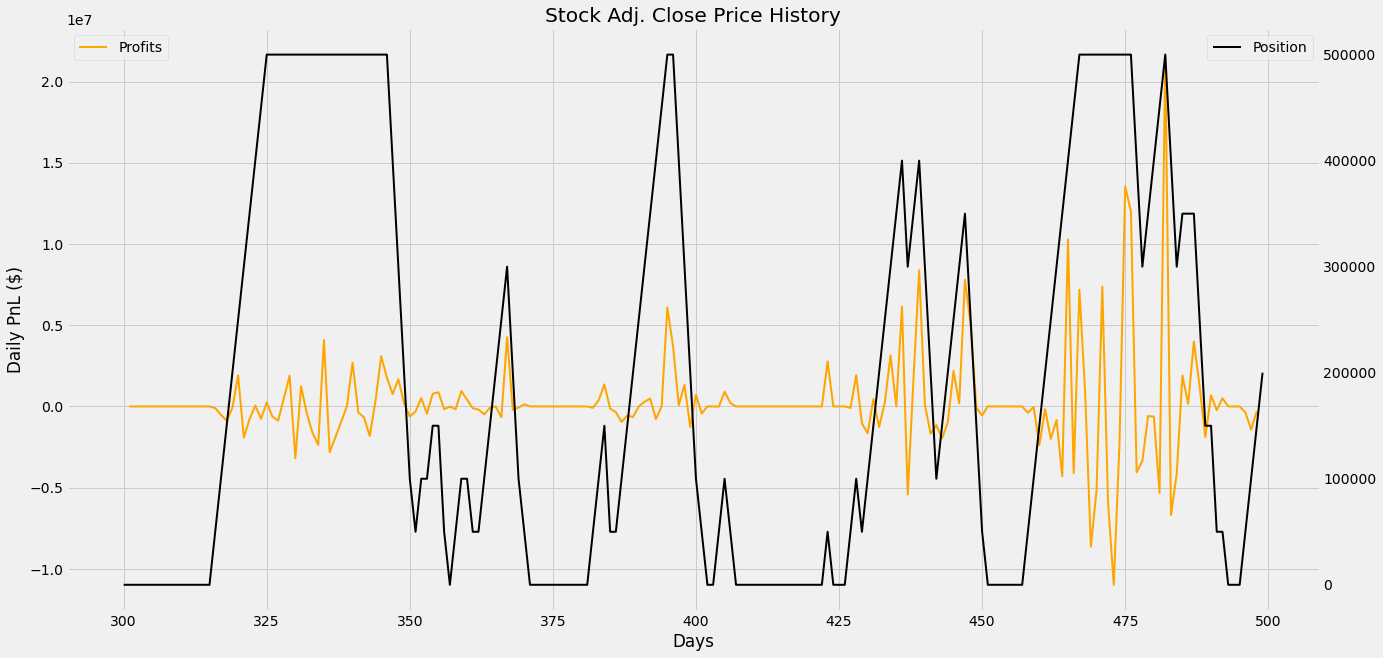

In [627]:
# Plotting Returns
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.plot(trades.index, trades['Profit'], linewidth=2, label='Profits', color='orange')
ax2.plot(trades.index, trades['Running Position'], linewidth=2, label='Position', color='black')
ax1.set_title('Stock Adj. Close Price History')
ax1.set_xlabel('Days')
#ax2.set_ylabel('Open Position ($)')
ax1.set_ylabel('Daily PnL ($)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.grid(False)
plt.show()

In [618]:
#Calculating returns

def Backtest(data, trades):
    
    profit = np.nansum(trades['Profit'])
    max_drawdown = max(trades['Profit'].dropna())
    
    return profit, max_drawdown

p, d = Backtest(vix, trades)
p

330324351.2974051

In [621]:

sharpe = ((252)**0.5)*np.nanmean(trades['Profit']-trades['Risk Free Return'])/np.nanstd(trades['Profit']-trades['Risk Free Return'])
sortino = ((252)**0.5)*np.nanmean(trades['Profit']-trades['Risk Free Return'])/np.nanstd(trades['Profit'][trades['Profit']<0])

sharpe
sortino

np.percentile(trades['Profit'].dropna(), 5)/(500000*85)

-0.05224844428789487

In [326]:
# optimising parameters

def Optimiser(data, trade_size):
    
    # trade_size - increment of trades
    max = [0]
    
    for wm in np.linspace(2,200,20):
            for ub in np.linspace(0,1,6):
                for lb in np.linspace(0,1,6):
                    for tss in np.linspace(100000,100000,1):
                        for tsb in np.linspace(70000,70000,1):
                    
                            buy_sell_data = vixen(vix, int(wm), ub, lb, tss, tsb)
                            trades = pd.DataFrame(vix.index)
                            trades['Price'] = vix.values
                            trades['Running Position'] = buy_sell_data[2]
                            trades['Trades'] = buy_sell_data[3]
                            trades['Profit'] = (trades['Price'][1::]-trades['Price'].shift(1)[0:-1]) * trades['Running Position']
                            trades['Cumulative Profit'] = trades['Profit'].cumsum()
                            trades = trades.set_index('Day')

                            # profit for tested parameters
                            profit = Backtest(data, trades)[0]

                            #print(profit, tss, tsb)

                            if profit > max[0]:
                                max = [profit, wm, ub, lb, tss, tsb]
                    
    return max
    
for i in np.arange(1):
    vix = df['Series 28']
    print(Optimiser(vix, 100000))

TypeError: vixen() missing 1 required positional argument: 'cap_size'

## Placing New Trades

In [50]:
# imports
from openpyxl import load_workbook

# Trade Placer
test = pd.read_excel('Test Bed.xlsx', usecols='A:E')
test = test.set_index('Day')

# variables
# =========================================
window_mean = 12
upper_bound = 0.01   # number of stdv from mean
lower_bound = 0.01    # number of stdv below mean
trade_size_sell = 100000    # daily trade increment
trade_size_buy = 50000    # daily trade increment
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = vixen(test['Market Price'], window_mean, upper_bound, lower_bound, trade_size_sell, trade_size_buy)

# format outputs
trades = pd.DataFrame(test.index)
trades['Trades'] = buy_sell_data[3]
trades = trades.set_index('Day')

# write to excel
#load excel file
workbook = load_workbook(filename="Test Bed.xlsx")
 
#open workbook
sheet = workbook.active
 
#modify the desired cell
for i in np.arange(3,trades.index[-2]+2):
    edit = 'C'+str(int(i))
    sheet[edit] = trades['Trades'][i-2]
 
# save the file
workbook.save(filename="Test Bed.xlsx")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


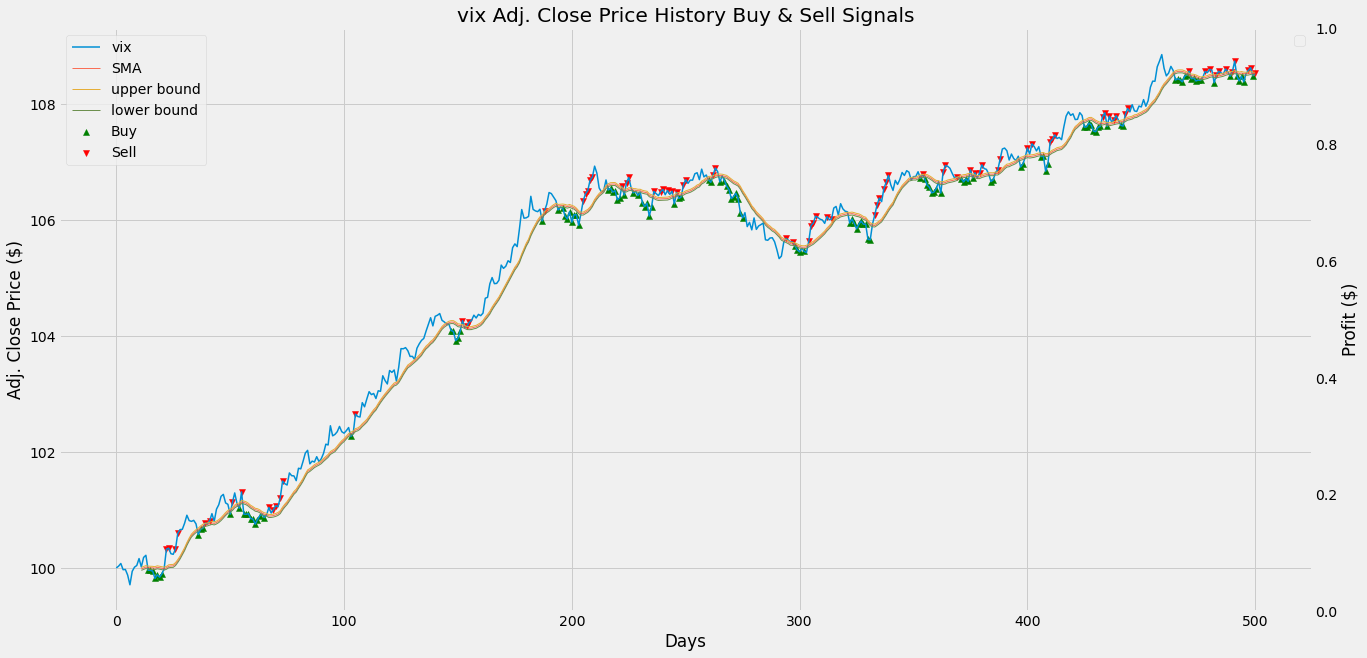

In [51]:
# Checking plotted to excel correctly
# visualise test

vix = test['Market Price']
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

# adding price data
ax1.plot(vix, label='vix', alpha=1, linewidth=1.5)
ax1.plot(vix.rolling(window=window_mean).mean(), label='SMA', alpha=0.8, linewidth=1)
ax1.plot(vix.rolling(window=window_mean).mean() + upper_bound*vix.std()\
         , linewidth=1, label='upper bound')
ax1.plot(vix.rolling(window=window_mean).mean() - lower_bound*vix.std()\
         , linewidth=1, label='lower bound')
# plot profit
# adding indicators
ax1.scatter(vix.index, buy_sell_data[0], label='Buy', marker='^', color='green')
ax1.scatter(vix.index, buy_sell_data[1], label='Sell', marker='v', color='red')
ax1.set_title('vix Adj. Close Price History Buy & Sell Signals')
ax1.set_xlabel('Days')
ax1.set_ylabel('Adj. Close Price ($)')
ax2.set_ylabel('Profit ($)')
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [52]:
buy_sell_data

([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  99.9598601521013,
  99.95872071621825,
  99.94390986258742,
  99.81821628576972,
  99.88040240895735,
  99.84112882744294,
  99.8953356827478,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  100.5763443458065,
  100.667077457138,
  100.6826165118347,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  100.9279693889531,
  nan,
  nan,
  nan,
  101.0306763200363,
  nan,
  100.9280701106228,
  100.925897077893,
  100.9352317341176,
  100.8527502292095,
  100.8434390766063,
  100.7554861894017,
  100.8348342113828,
  100.8999009122616,
  nan,
  100.8700731824954,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  n